In [ ]:
!pip install captum

In [ ]:
!pip install lime

In [ ]:
!pip install grad-cam

In [ ]:
!pip install torchcam

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, Occlusion
import torch.optim as optim
from captum.attr import LayerGradCam, visualization as viz
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import random

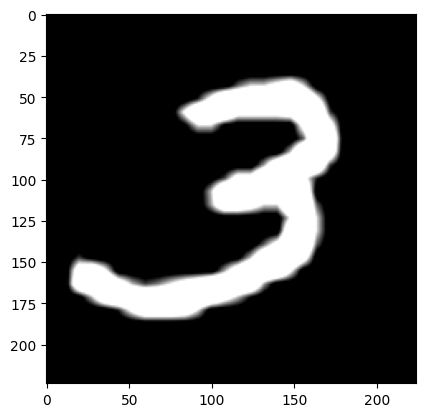

Predicted Class: 600


In [ ]:
# Define the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations to adapt MNIST to the model (from Grayscale to RGB and resizing)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels (RGB)
    transforms.Resize((224, 224)),  # Resize to match DenseNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and standard deviation for MNIST
])

# Load the MNIST dataset (train and test)
mnist_dataset_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_dataset_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create a DataLoader for MNIST
data_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=1, shuffle=True)



# Load the pre-trained DenseNet model
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT).to(device)

# Function to display an image
def imshow(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Load a batch of images
images, labels = next(iter(data_loader))
images = images.to(device)

# Display a random image
imshow(images[0])

# Make a prediction with the pre-trained model
output = model(images)
predicted_class = torch.argmax(output, 1).item()
print(f"Predicted Class: {predicted_class}")

# Define new model from scratch

In [ ]:
# Define the Classifier model (custom model)
class Classifier(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, padding=1)
        self.dense = nn.Linear(out_channels * 56 * 56, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x

In [ ]:
# Load the custom model and train it
epoch = 1
batch_size = 32
data_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)
model = Classifier().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
loss_history = []
loss_history_test = []

for e in range(epoch):
    for images, labels in torch.utils.data.DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True):
        model.train()
        images = images.to(device)
        labels = labels.to(device)

        predicted_class = model(images)
        loss = loss_fn(predicted_class, labels)
        print(f"Loss: {loss.item()}")

        # Calculate accuracy
        predicted = predicted_class.softmax(-1).argmax(-1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        print(f"Accuracy: {accuracy}")
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(test_dataloader))
            images = images.to(device)
            labels = labels.to(device)

            predicted_class = model(images)
            loss = loss_fn(predicted_class, labels)
            print(f"Loss on test set: {loss.item()}")

            # Accuracy evaluation
            predicted = predicted_class.softmax(-1).argmax(-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            print(f"Accuracy on test set: {accuracy}")
            loss_history_test.append(loss.item())




Output streaming troncato alle ultime 5000 righe.
Loss: 0.020778808742761612
Accuracy: 1.0
Loss on test set: 0.20845988392829895
Accuracy on test set: 0.9375
Loss: 0.09407626837491989
Accuracy: 0.96875
Loss on test set: 0.2702844738960266
Accuracy on test set: 0.90625
Loss: 0.1740243136882782
Accuracy: 0.9375
Loss on test set: 0.026460954919457436
Accuracy on test set: 1.0
Loss: 0.058069635182619095
Accuracy: 0.96875
Loss on test set: 0.03314623236656189
Accuracy on test set: 1.0
Loss: 0.03552247956395149
Accuracy: 1.0
Loss on test set: 0.20108377933502197
Accuracy on test set: 0.9375
Loss: 0.5688662528991699
Accuracy: 0.9375
Loss on test set: 0.1502867192029953
Accuracy on test set: 0.9375
Loss: 0.1318698674440384
Accuracy: 1.0
Loss on test set: 0.0679459497332573
Accuracy on test set: 0.96875
Loss: 0.18983688950538635
Accuracy: 0.96875
Loss on test set: 0.0975627526640892
Accuracy on test set: 0.96875
Loss: 0.35382506251335144
Accuracy: 0.9375
Loss on test set: 0.17795635759830475
Ac

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'MNIST_classifier.pth')

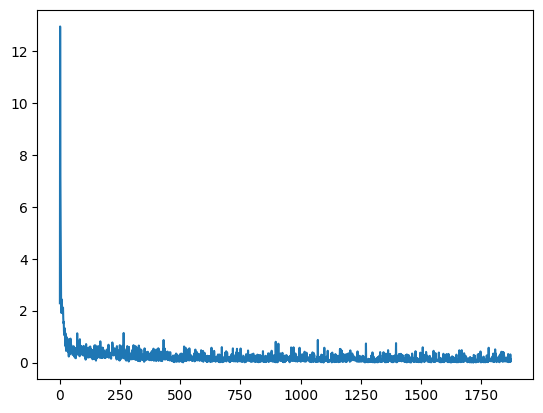

In [ ]:

# Plot the training loss
plt.plot(loss_history)


In [ ]:
# load the model
model = Classifier().to(device)
model.load_state_dict(torch.load('MNIST_classifier.pth'))
model.eval()

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense): Linear(in_features=200704, out_features=10, bias=True)
)

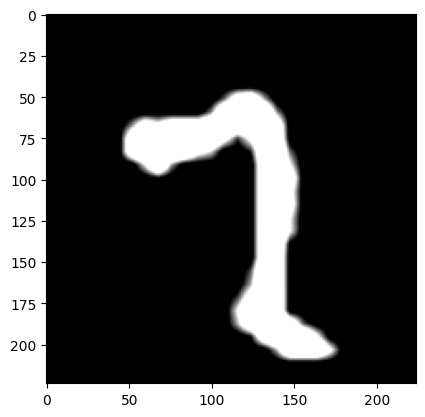

Predicted Class: 7


In [ ]:
# Load a batch of images
data_loader = DataLoader(mnist_dataset_train, batch_size=1, shuffle=True)
images, labels = next(iter(data_loader))
images = images.to(device)

# Display a random image
imshow(images[0])

# Make a prediction using the model
output = model(images)
predicted_class = torch.argmax(output, 1).item()
print(f"Predicted Class: {predicted_class}")

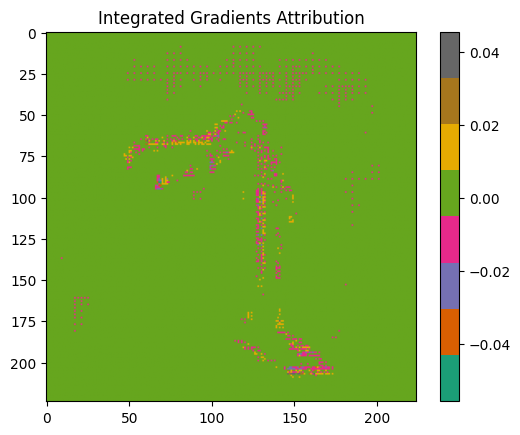

In [ ]:
# Calculate the Integrated Gradients
ingrad = IntegratedGradients(model)
images.requires_grad_()  # Enable gradient calculation
attributions, _ = ingrad.attribute(images, target=predicted_class, return_convergence_delta=True)

# Visualize the attributions
attr_np = attributions.squeeze().detach().cpu().numpy()
plt.imshow(attr_np[0], cmap='Dark2')
plt.colorbar()
plt.title("Integrated Gradients Attribution")
plt.show()

# Iterate on different classes

In [ ]:
# save 10 samples for each class of MNIST
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [ ]:
# prompt: save 10 samples for each class of MNIST, save in in separate list

# Create lists to store samples for each class
samples_per_class = {}
for i in range(10):
    samples_per_class[i] = []

# Iterate through the MNIST dataset
for image, label in mnist_dataset:
    if len(samples_per_class[label]) < 10:
        samples_per_class[label].append(image)

# Now samples_per_class contains 10 samples for each class (0-9)
# You can access them like this:
# samples_per_class[0]  # Contains 10 samples of digit 0
# samples_per_class[1]  # Contains 10 samples of digit 1
# and so on...


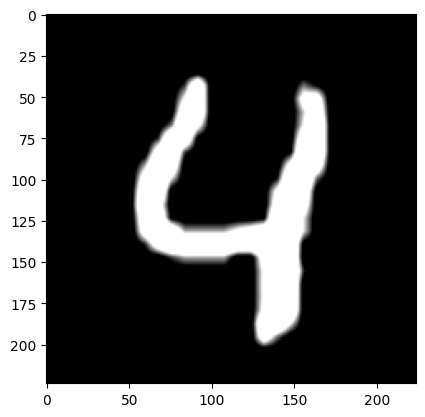

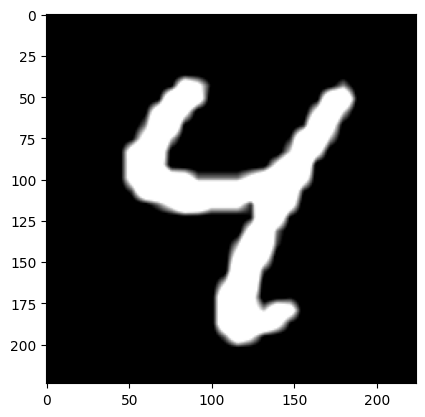

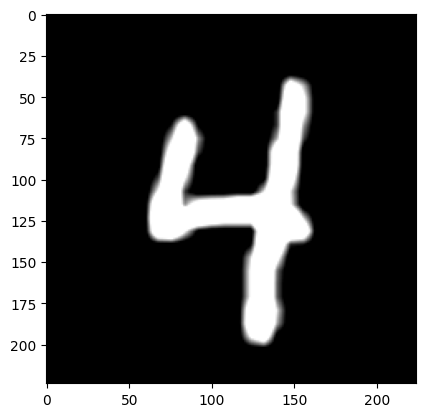

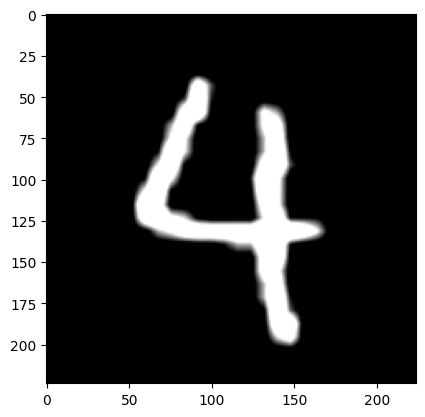

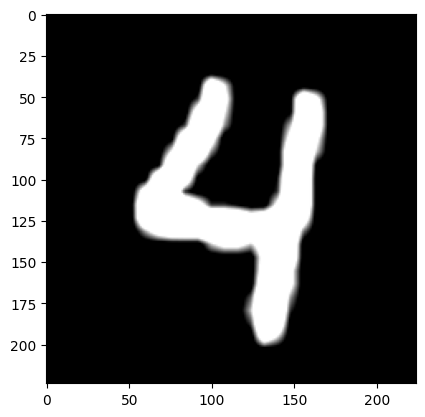

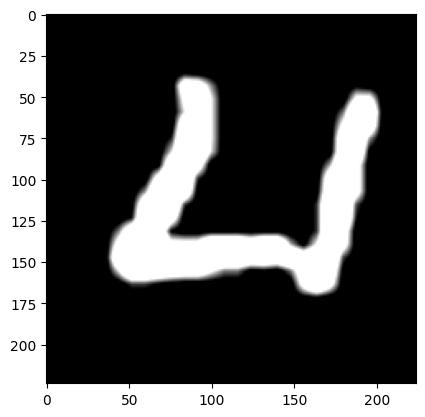

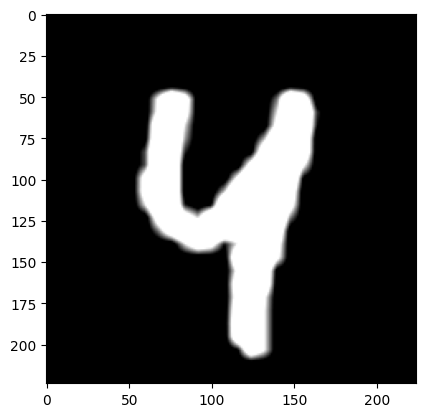

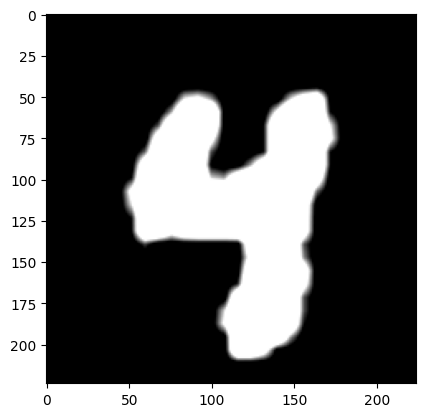

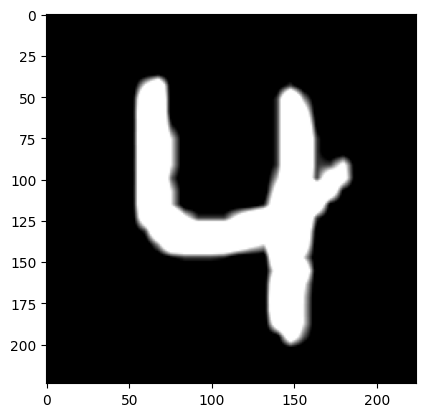

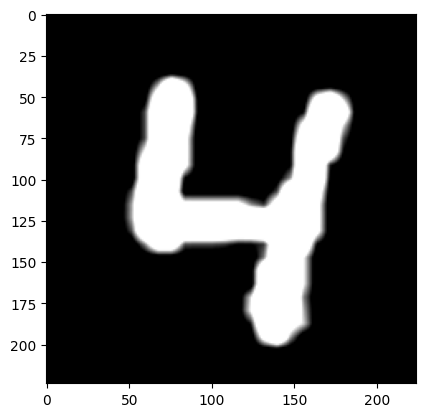

In [ ]:
label=4
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

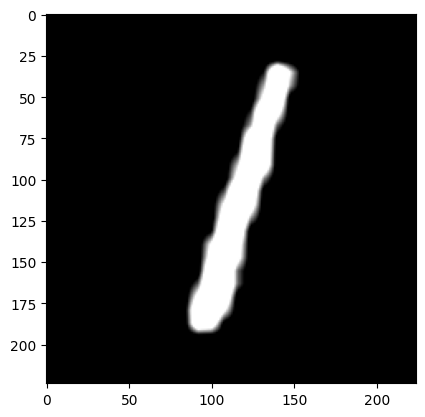

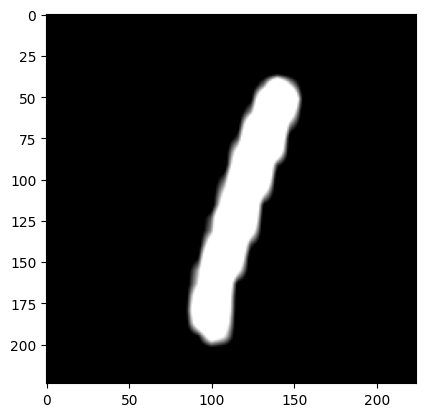

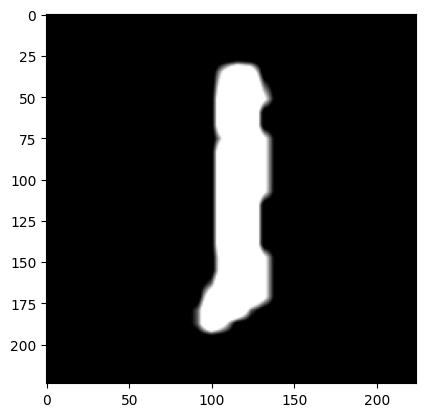

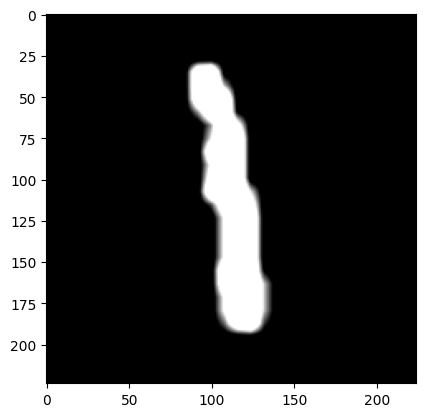

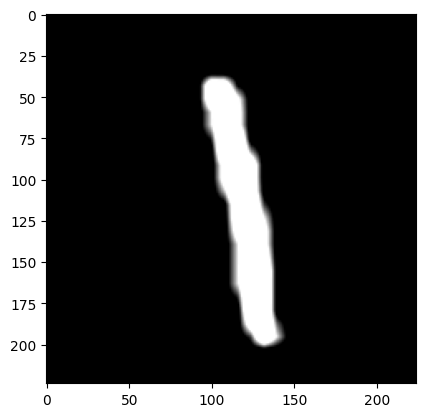

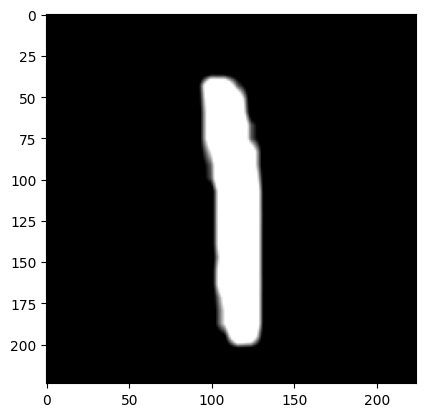

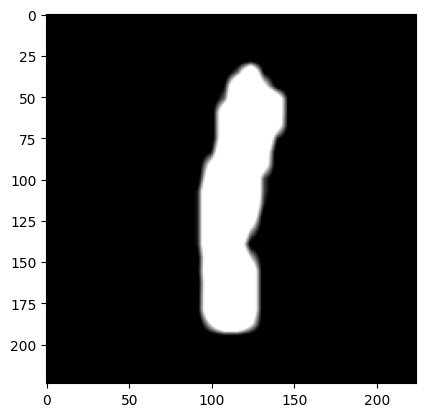

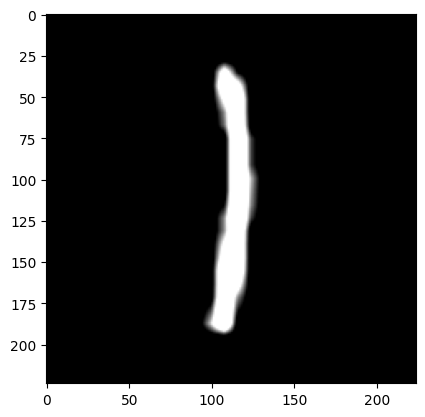

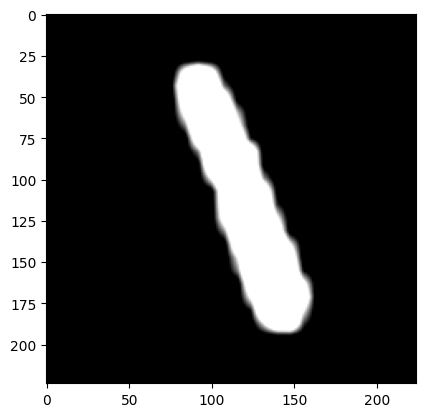

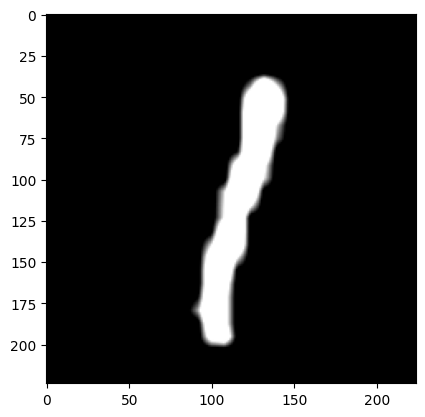

In [ ]:
label=1
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

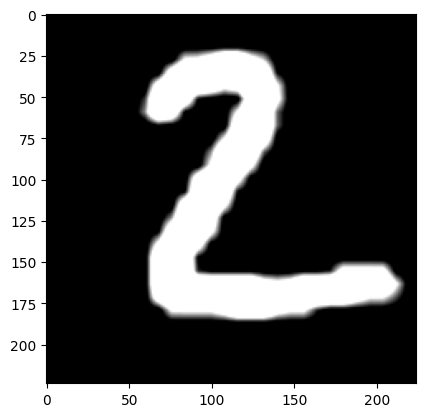

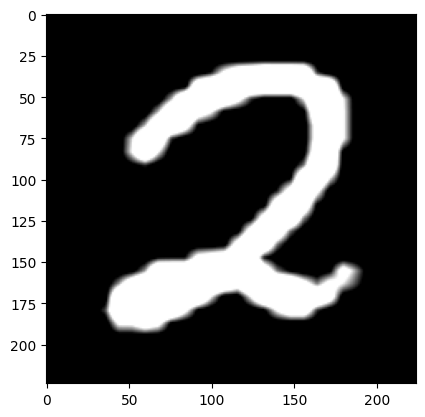

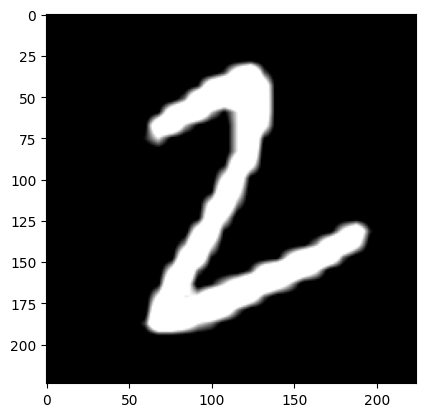

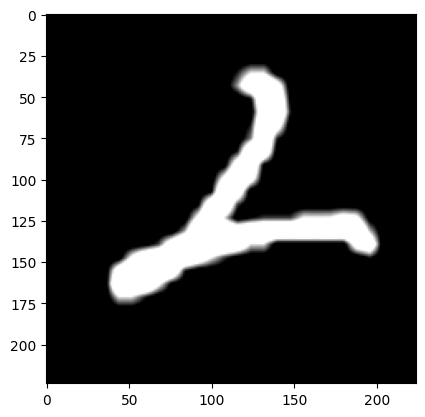

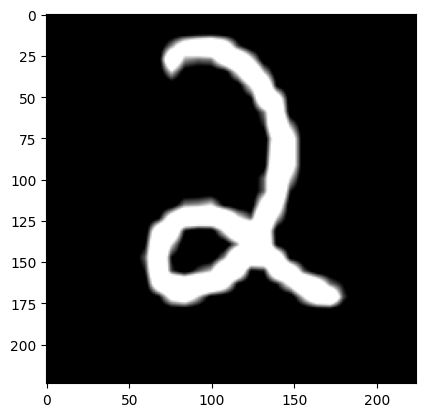

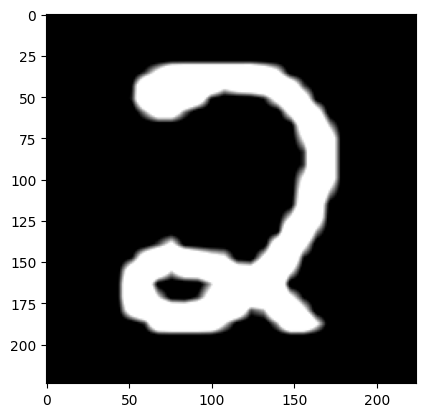

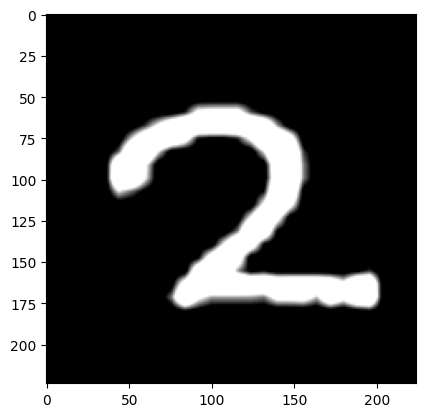

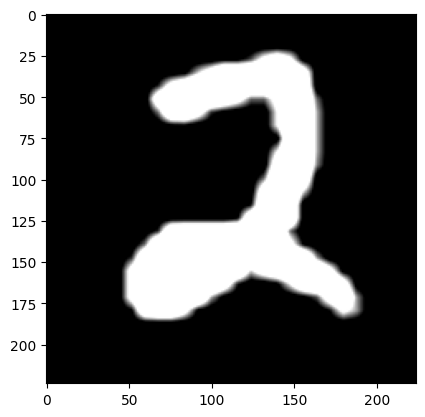

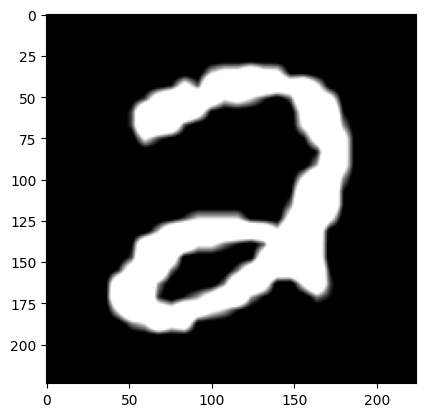

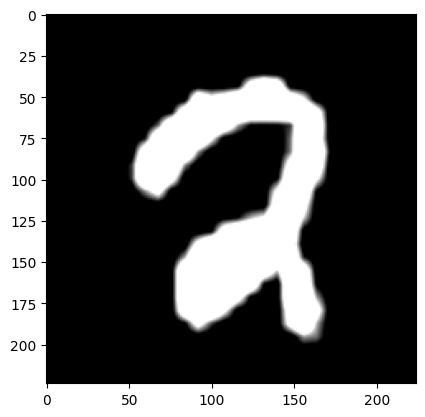

In [ ]:
label=2
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

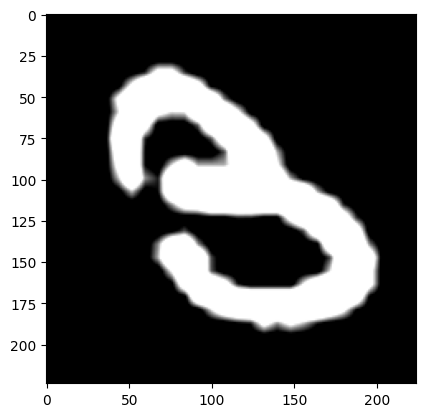

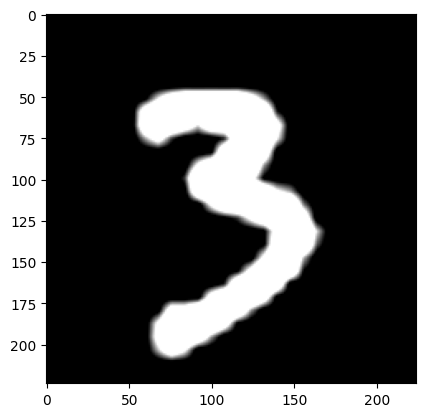

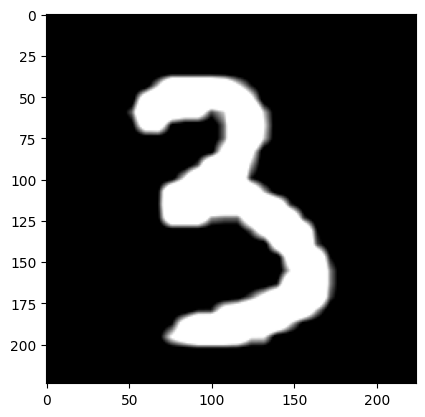

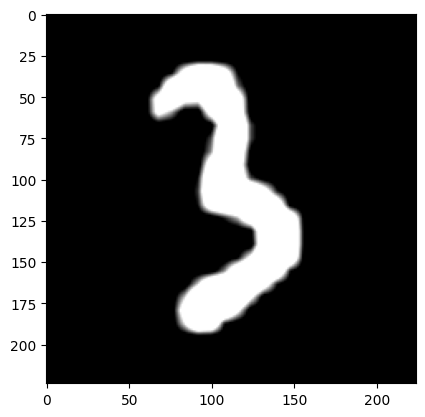

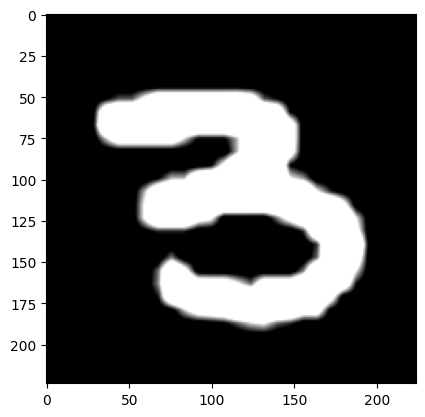

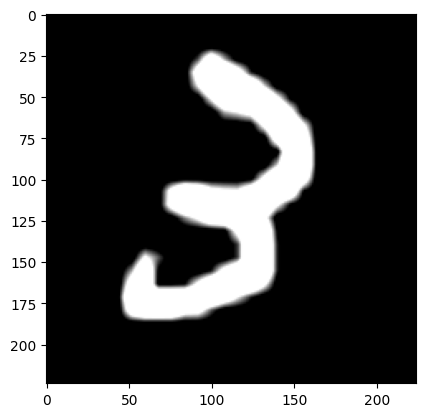

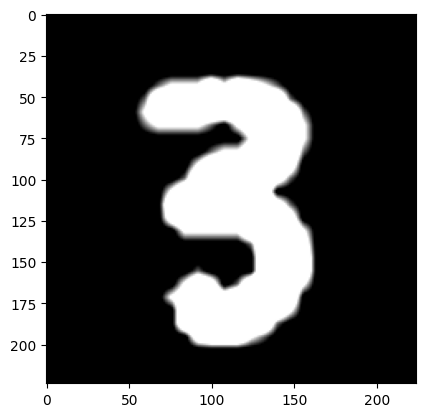

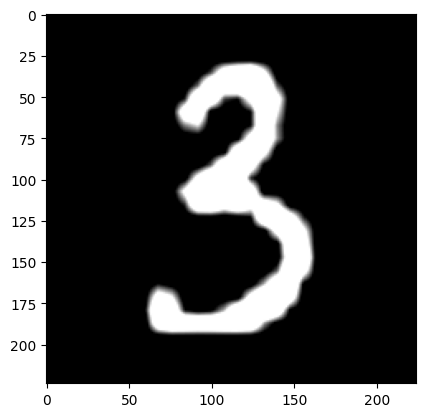

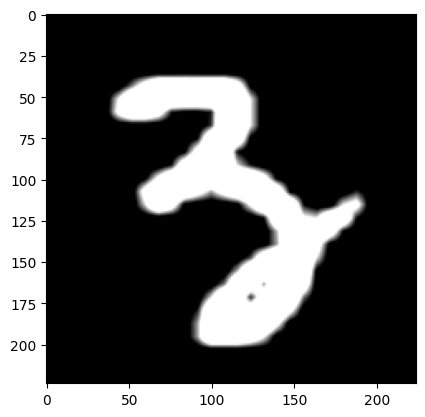

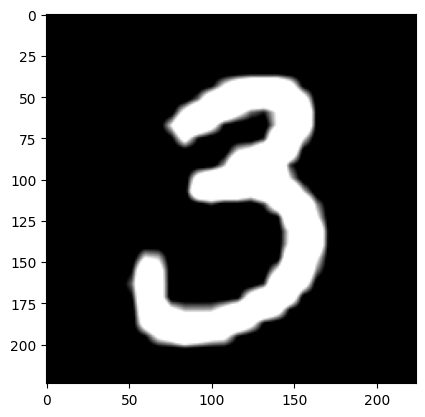

In [ ]:
label=3
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

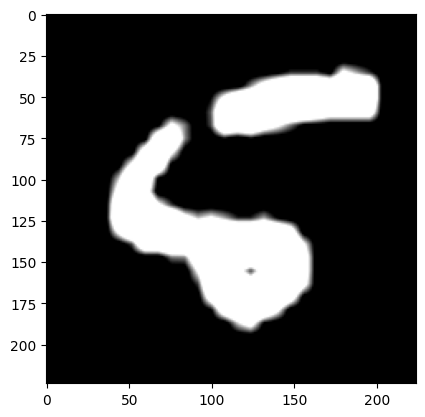

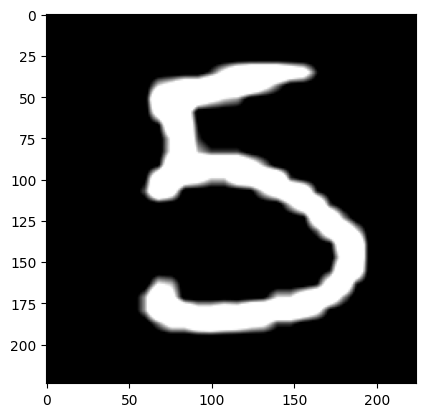

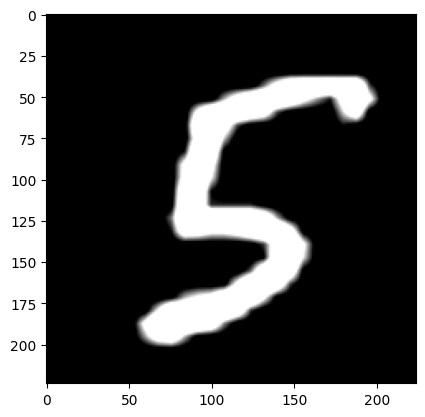

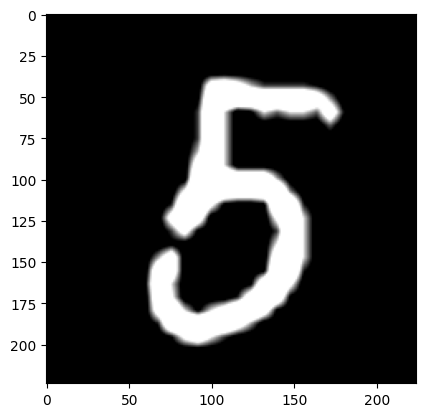

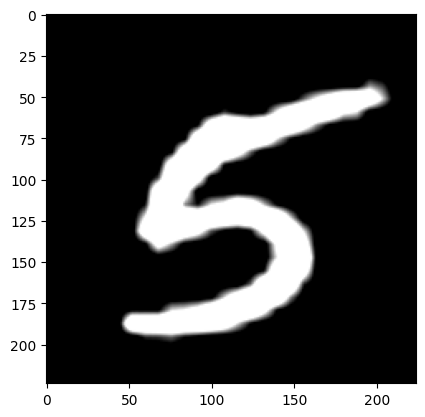

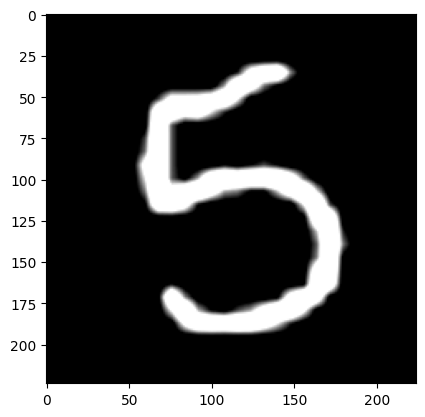

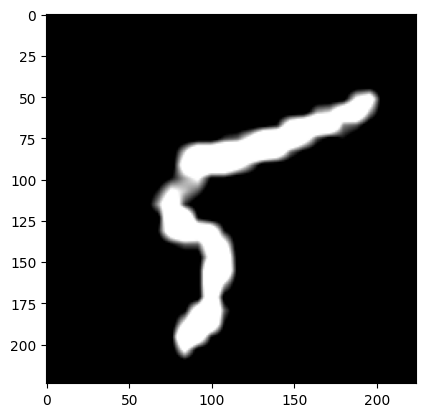

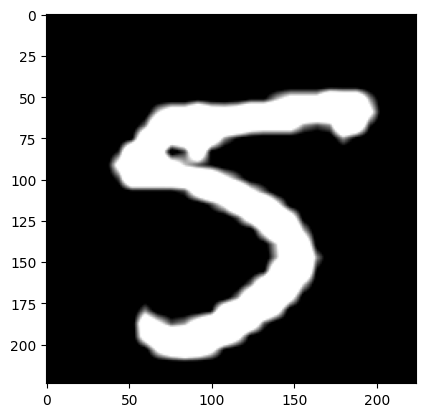

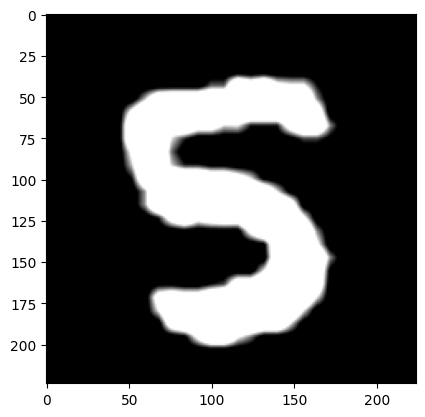

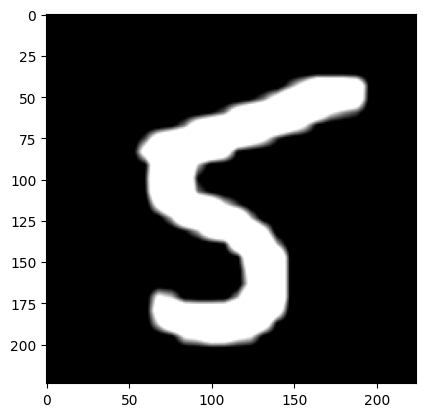

In [ ]:
label=5
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

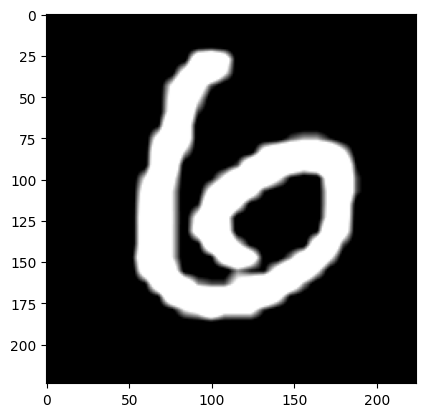

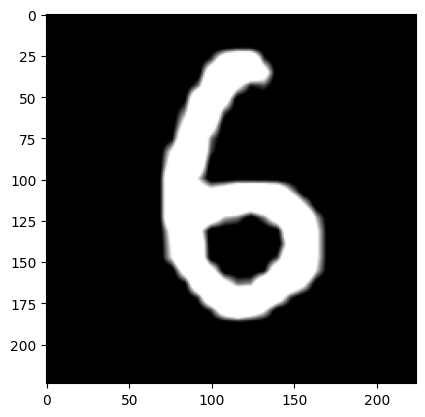

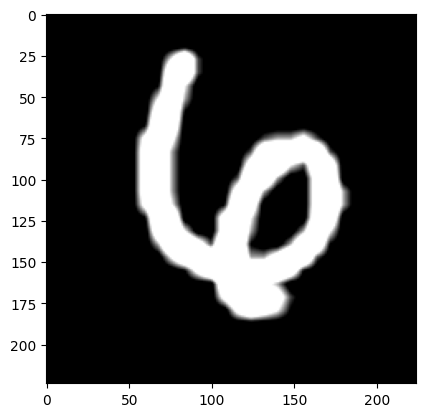

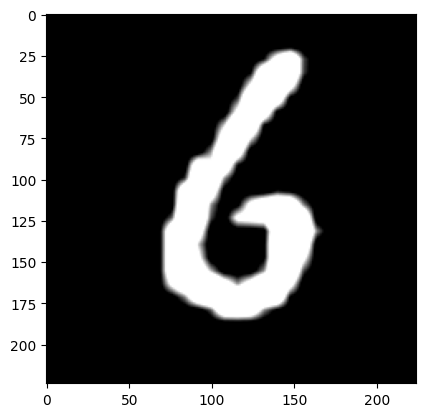

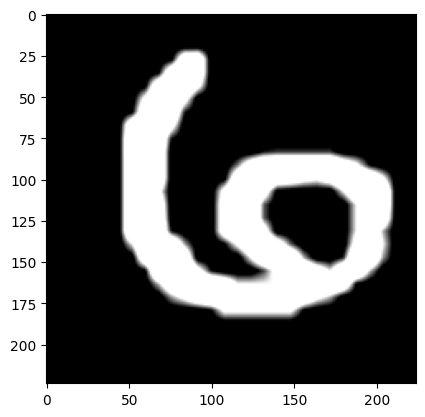

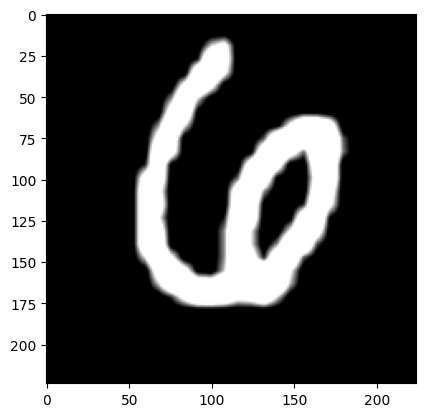

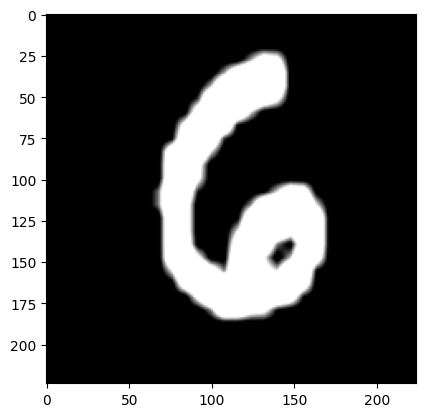

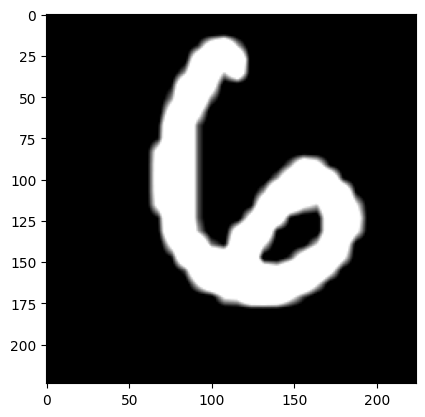

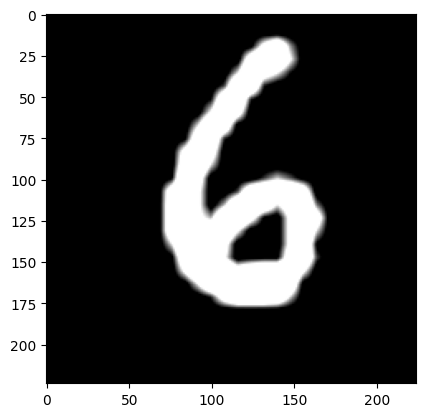

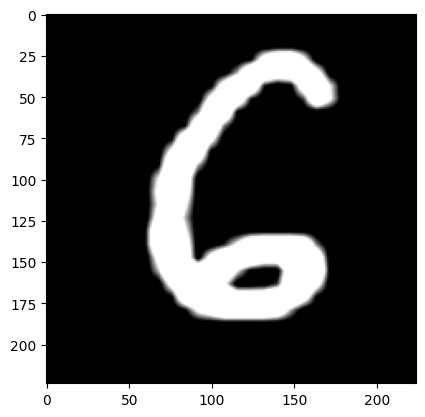

In [ ]:
label=6
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

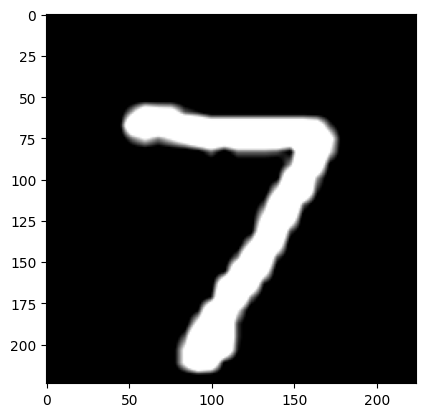

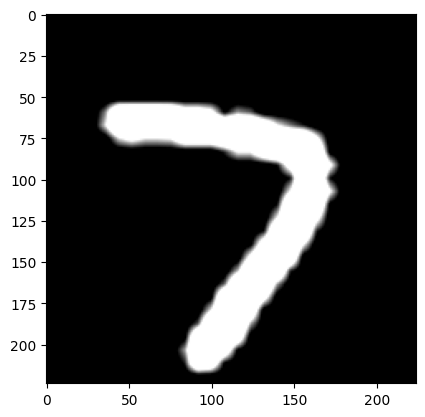

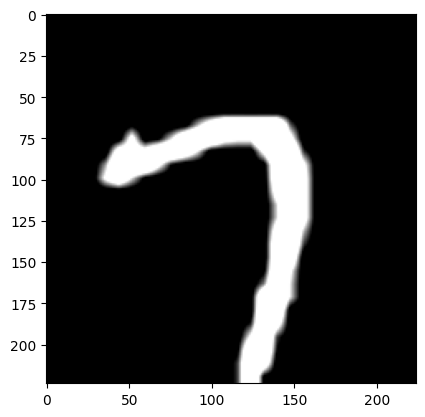

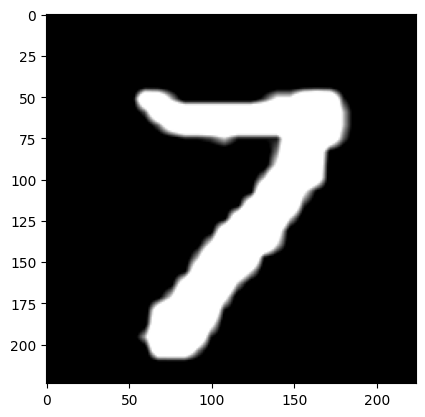

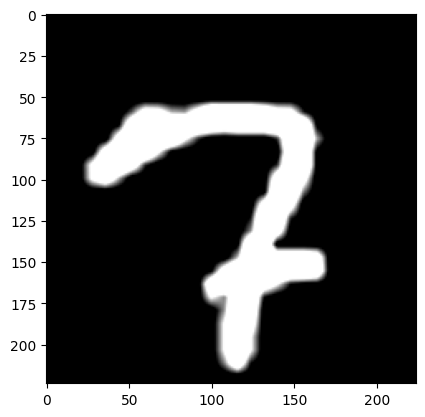

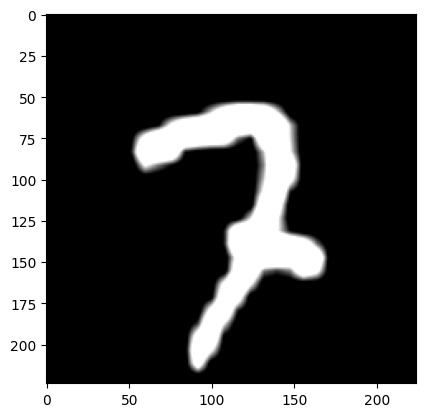

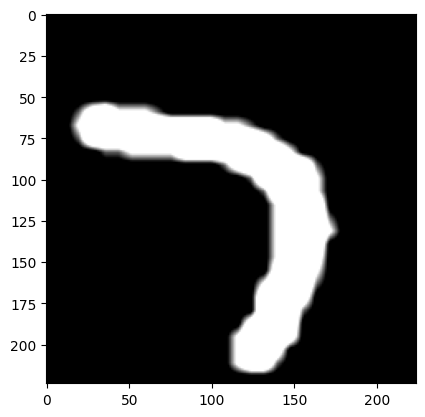

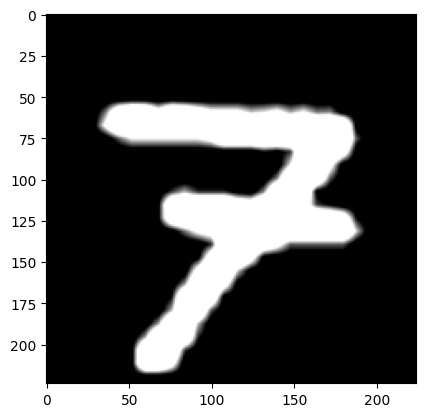

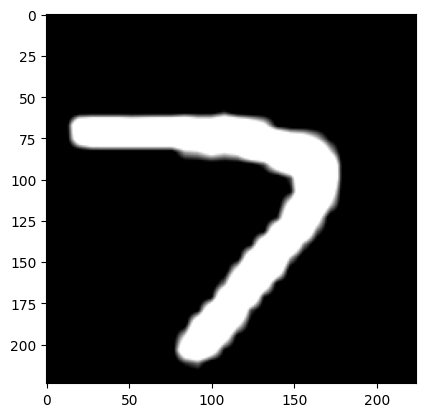

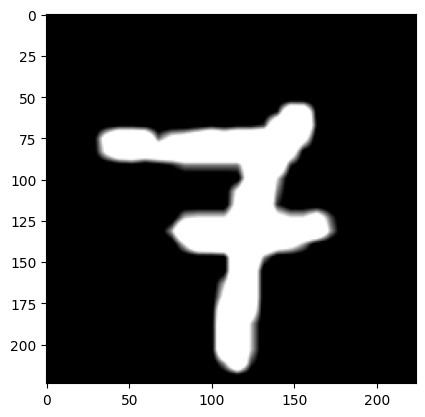

In [ ]:
label=7
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

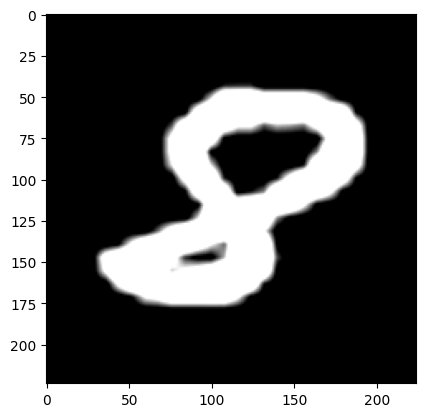

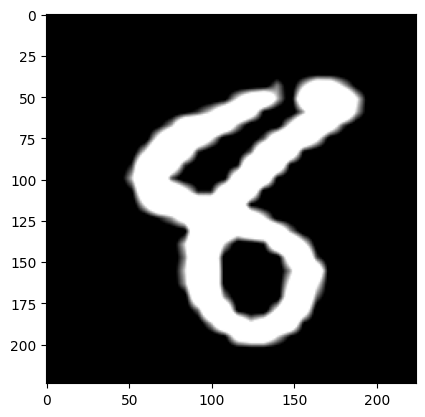

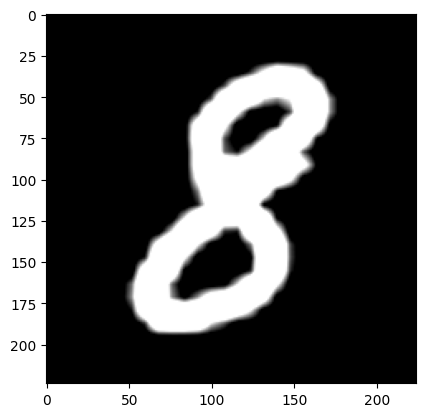

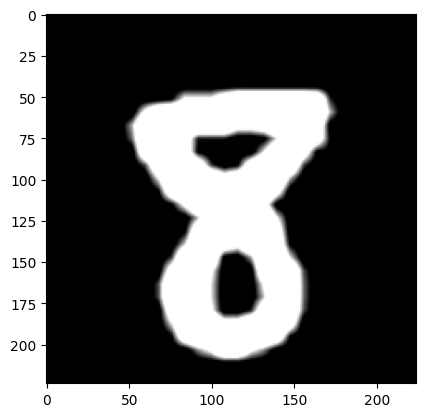

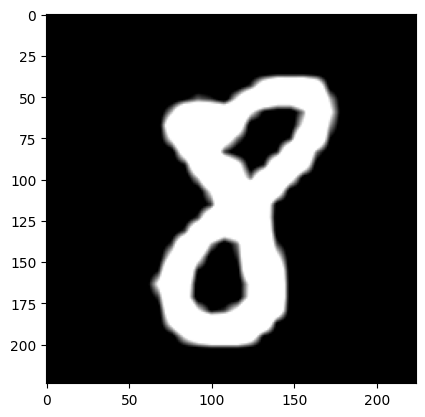

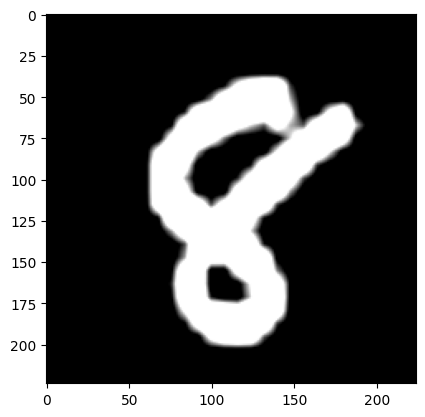

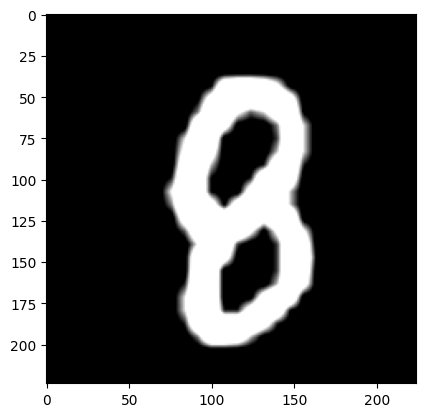

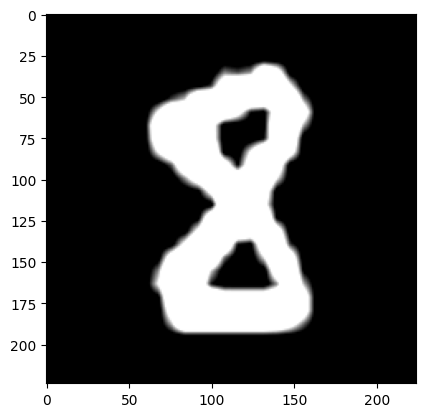

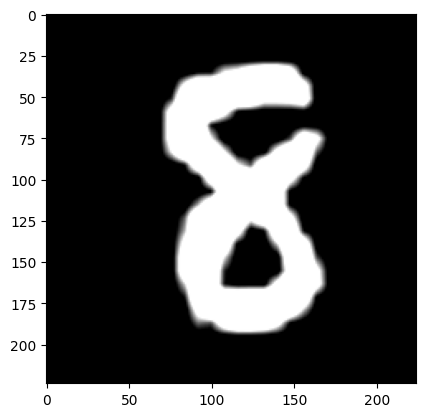

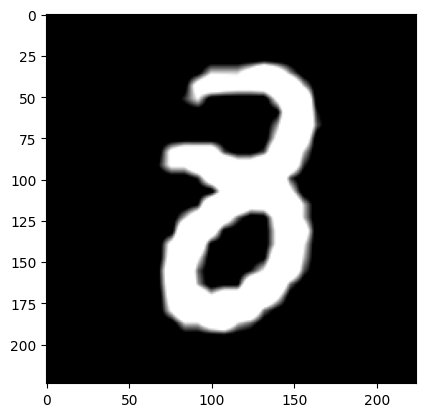

In [ ]:
label=8
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

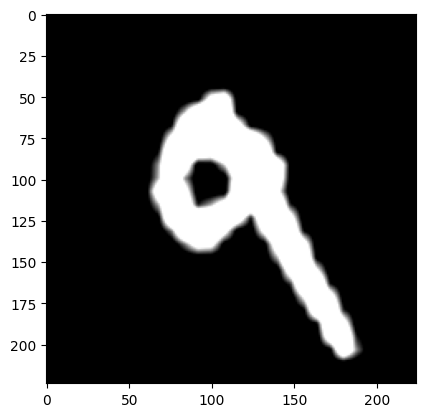

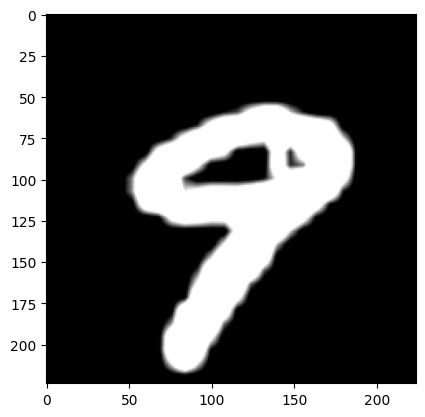

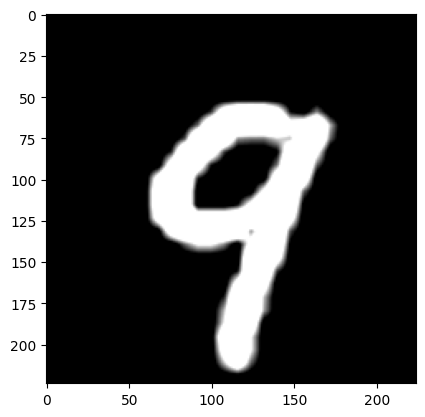

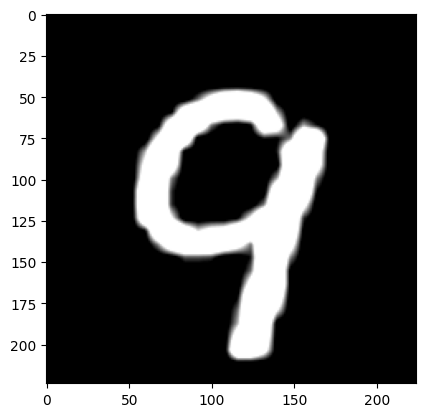

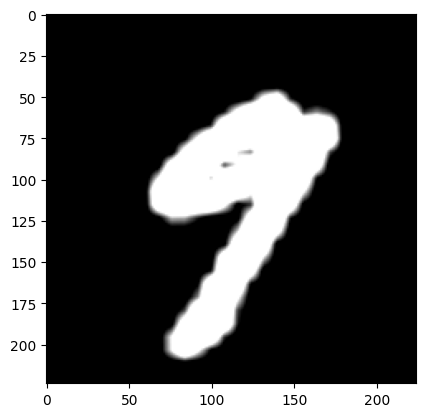

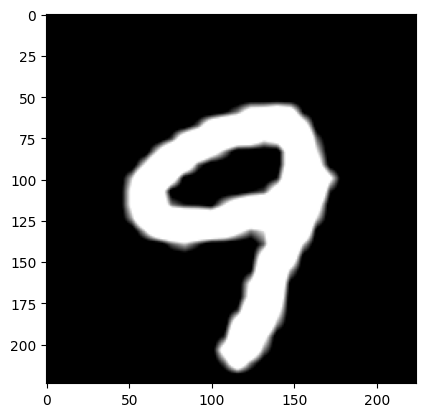

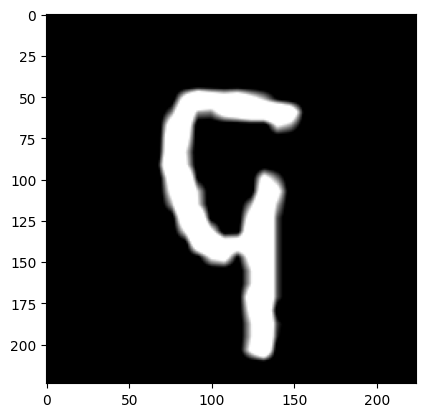

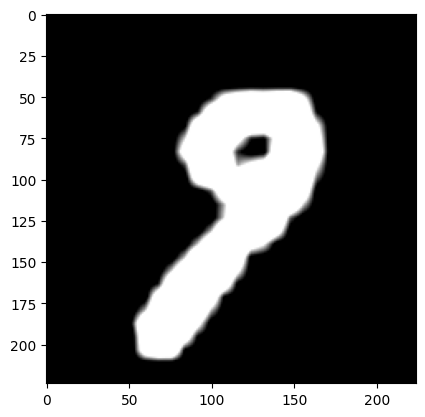

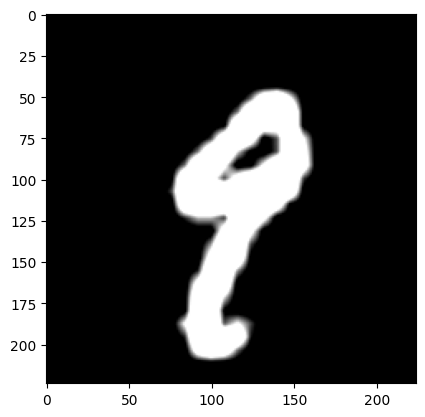

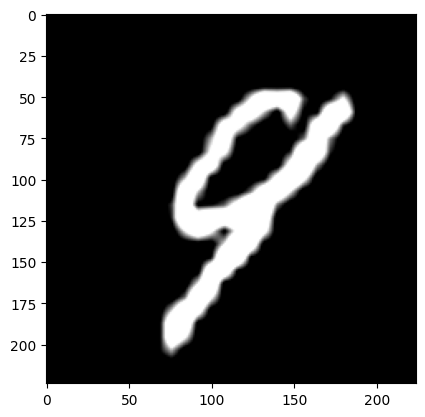

In [ ]:
label=9
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

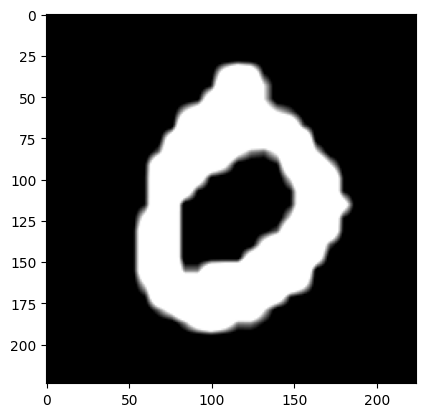

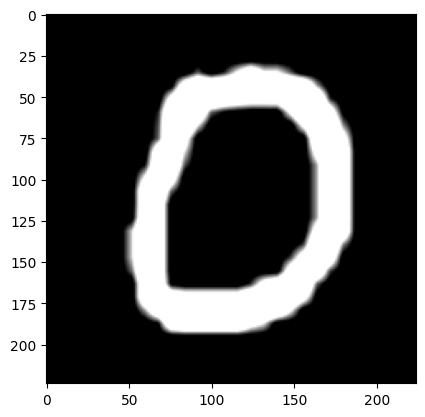

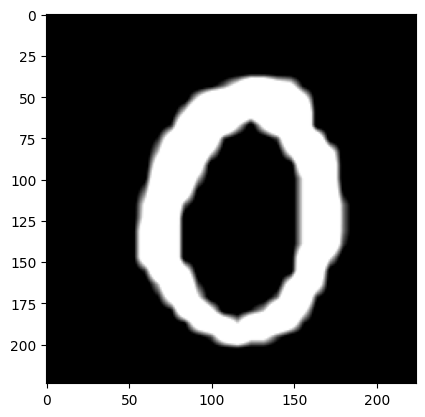

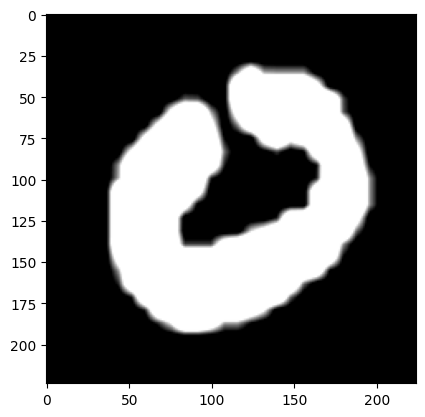

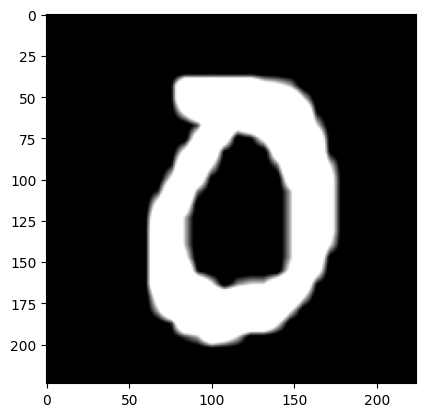

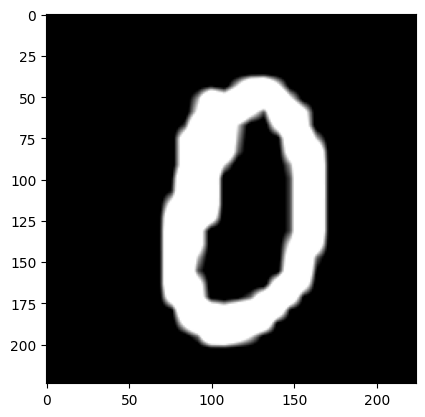

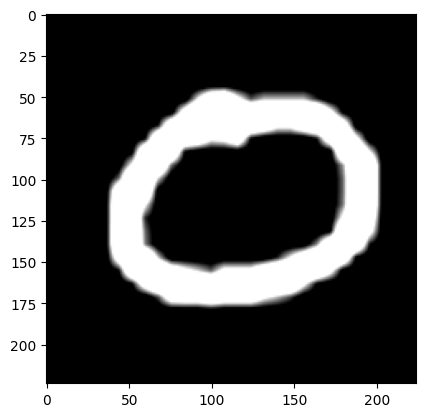

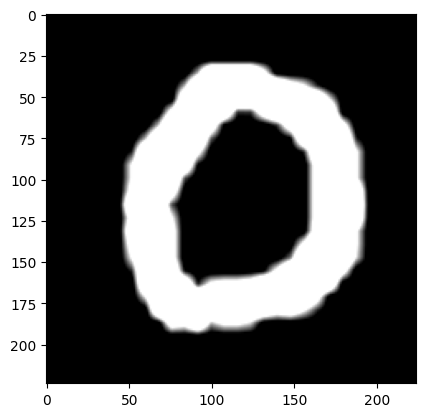

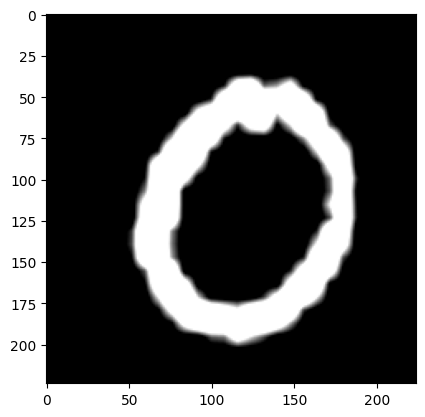

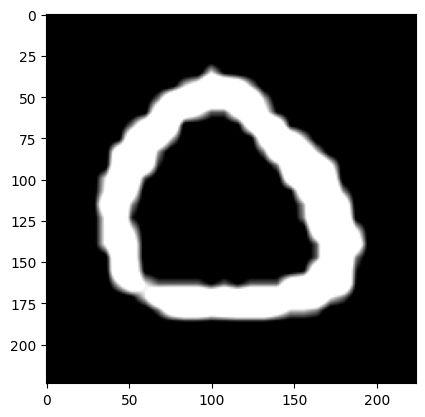

In [ ]:
label=0
samples_per_class[label]
for image in samples_per_class[label]:
  imshow(image)

In [ ]:
print(model)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense): Linear(in_features=200704, out_features=10, bias=True)
)


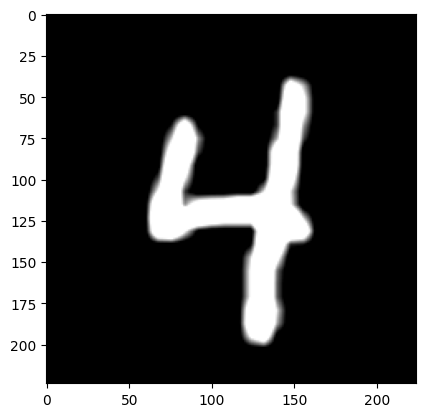

Predicted Class: 4


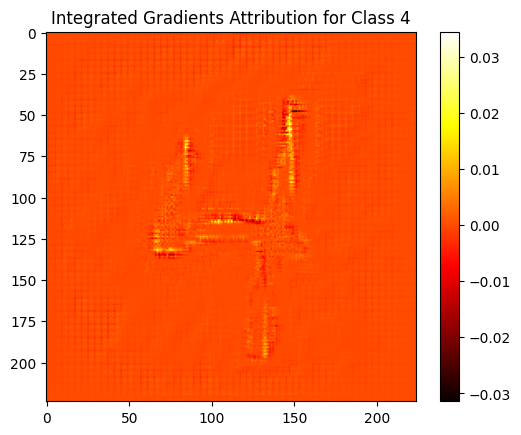

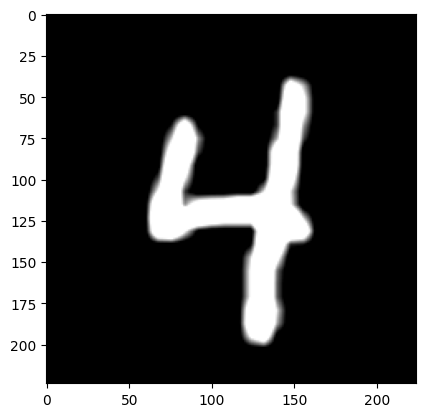

Predicted Class: 4


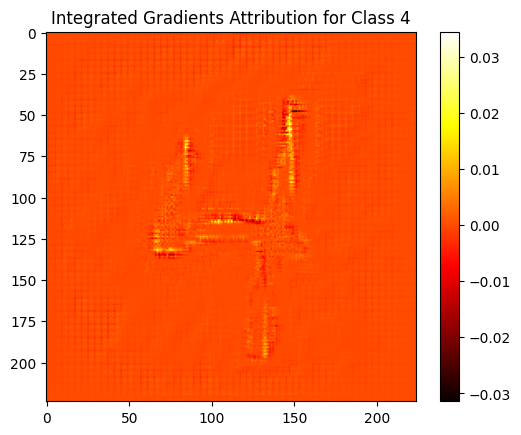

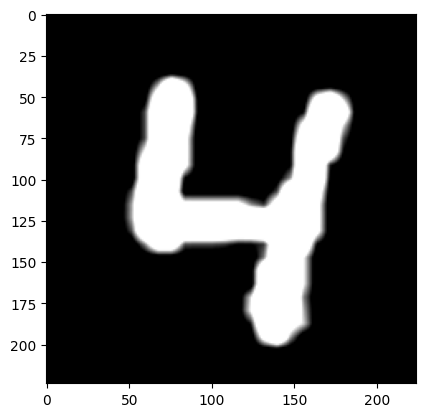

Predicted Class: 4


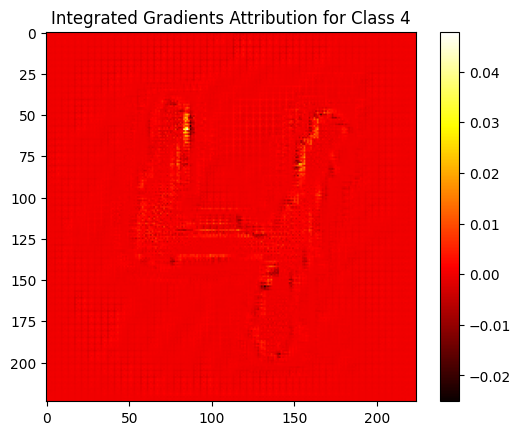

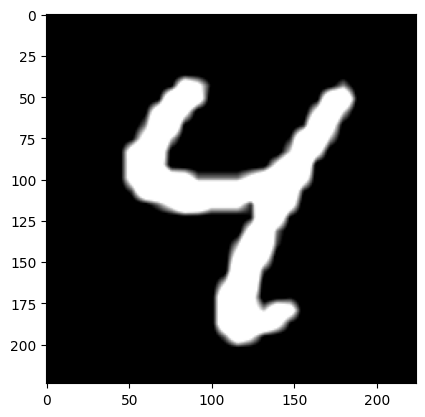

Predicted Class: 4


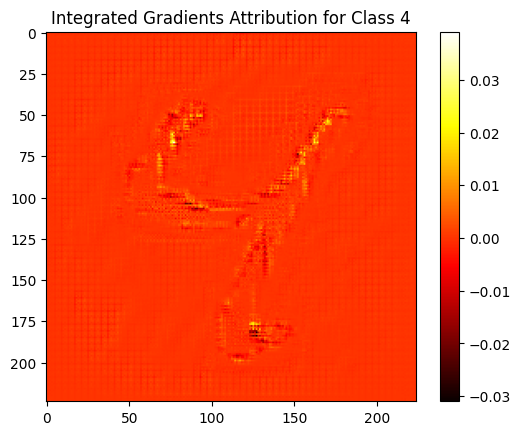

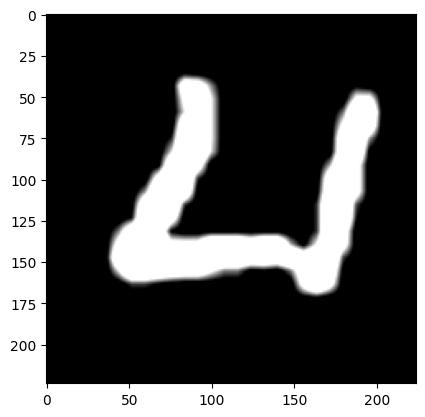

Predicted Class: 4


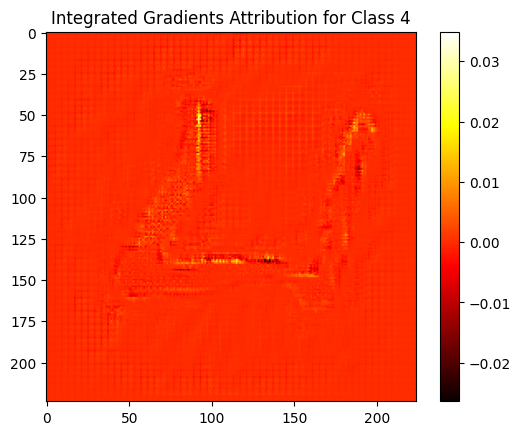

In [ ]:
# Select a class to display the Integrated Gradients (e.g., class 4)
label = 4
samples_for_class = samples_per_class[label]

# Load the trained model
model = Classifier().to(device)
model.load_state_dict(torch.load('MNIST_classifier.pth'))

# Initialize Integrated Gradients
ingrad = IntegratedGradients(model)

# Loop through 5 random images for class 4
for i in range(5):
    # Extract a single random image from the already created batch
    image = random.choice(samples_for_class).to(device).unsqueeze(0)  # Choose a random image

    # Display the image
    imshow(image[0])

    # Prediction with the model
    output = model(image)
    predicted_class = torch.argmax(output, 1).item()
    print(f"Predicted Class: {predicted_class}")

    # Calculate the Integrated Gradients
    image.requires_grad_()  # Enable gradient calculation
    attributions, _ = ingrad.attribute(image, target=predicted_class, return_convergence_delta=True)

    # Handle the attribution for visualization
    attr_np = attributions.squeeze().detach().cpu().numpy()
    if attr_np.ndim == 3:  # If it's 3D (e.g., with RGB channels)
        attr_np = np.mean(attr_np, axis=0)  # Average the channels to display in 2D

    # Visualize the attributions
    plt.imshow(attr_np, cmap='hot')  # Use the 'hot' colormap to highlight the most important areas
    plt.colorbar()
    plt.title(f"Integrated Gradients Attribution for Class {predicted_class}")
    plt.show()

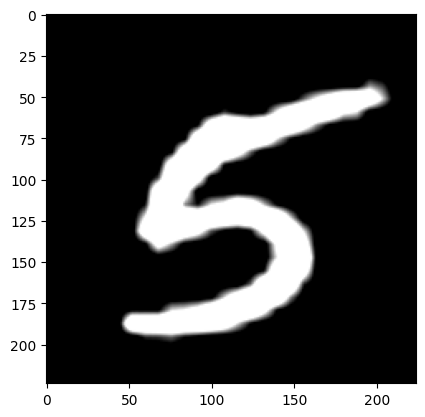

Predicted Class: 5


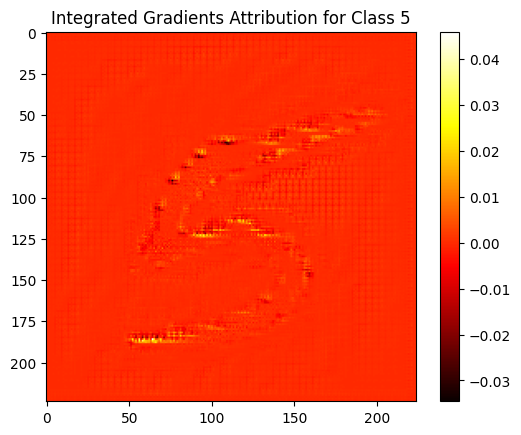

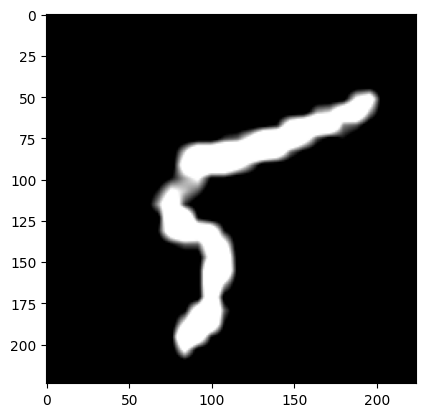

Predicted Class: 5


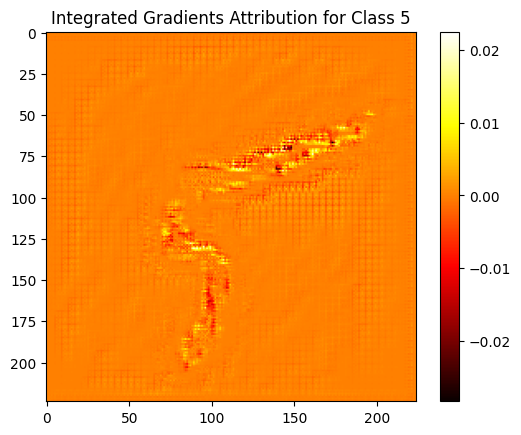

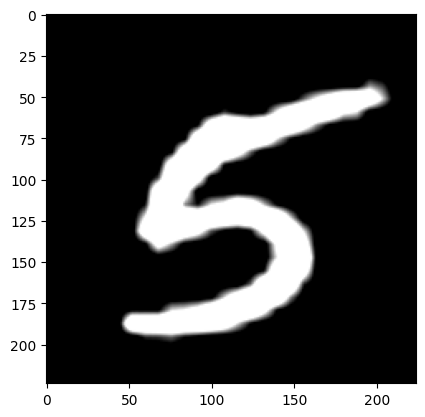

Predicted Class: 5


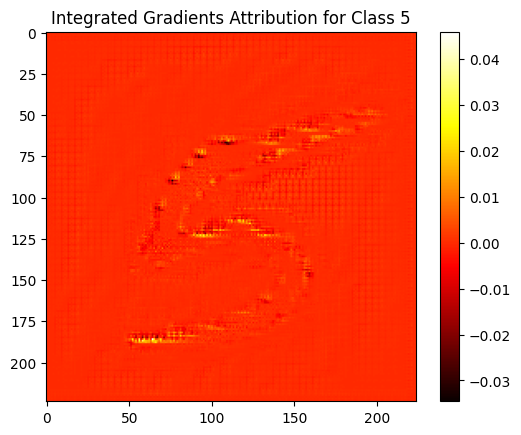

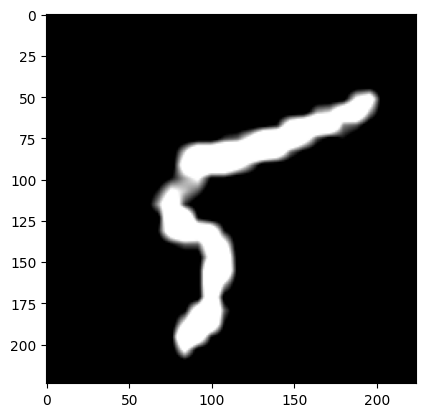

Predicted Class: 5


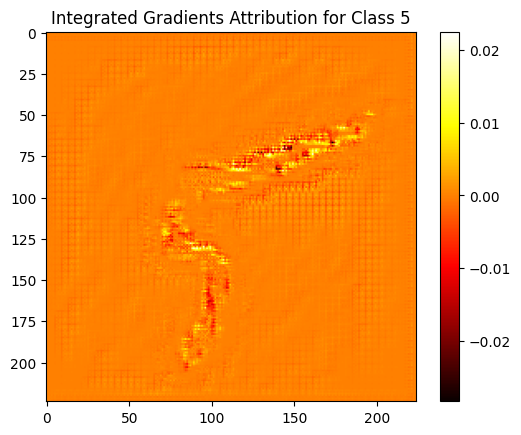

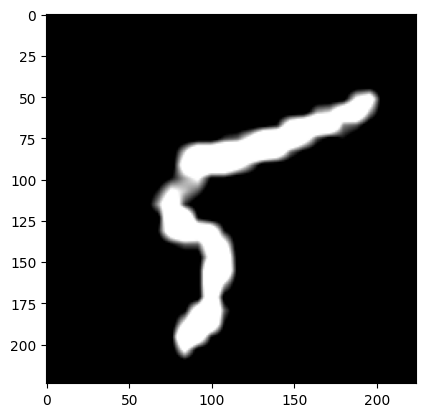

Predicted Class: 5


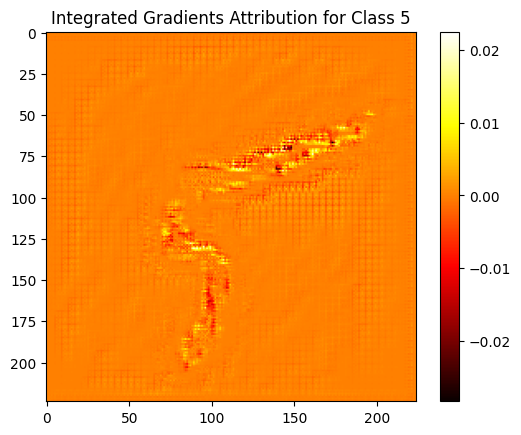

In [ ]:


# Select a class to display the Integrated Gradients (e.g., class 5)
label = 5
samples_for_class = samples_per_class[label]

# Load the trained model
model = Classifier().to(device)
model.load_state_dict(torch.load('MNIST_classifier.pth'))

# Initialize Integrated Gradients
ingrad = IntegratedGradients(model)

# Loop through 5 random images for class 5
for i in range(5):
    # Extract a single random image from the already created batch
    image = random.choice(samples_for_class).to(device).unsqueeze(0)  # Choose a random image

    # Display the image
    imshow(image[0])

    # Prediction with the model
    output = model(image)
    predicted_class = torch.argmax(output, 1).item()
    print(f"Predicted Class: {predicted_class}")

    # Calculate the Integrated Gradients
    image.requires_grad_()  # Enable gradient calculation
    attributions, _ = ingrad.attribute(image, target=predicted_class, return_convergence_delta=True)

    # Handle the attribution for visualization
    attr_np = attributions.squeeze().detach().cpu().numpy()
    if attr_np.ndim == 3:  # If it's 3D (e.g., with RGB channels)
        attr_np = np.mean(attr_np, axis=0)  # Average the channels to display in 2D

    # Visualize the attributions
    plt.imshow(attr_np, cmap='hot')  # Use the 'hot' colormap to highlight the most important areas
    plt.colorbar()
    plt.title(f"Integrated Gradients Attribution for Class {predicted_class}")
    plt.show()


Predicted Class: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

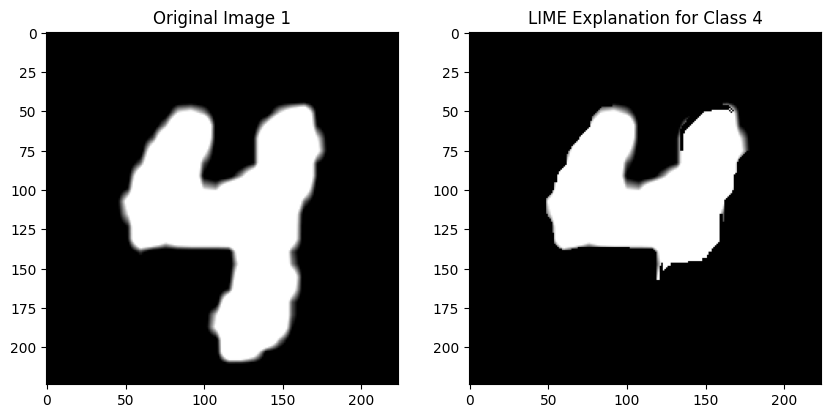

Predicted Class: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

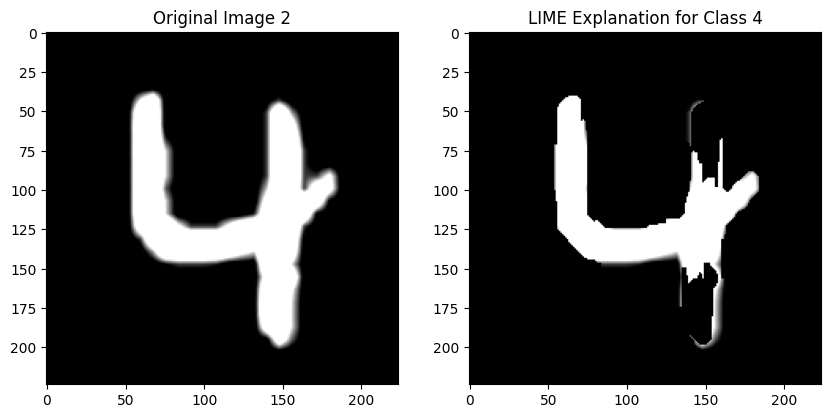

Predicted Class: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

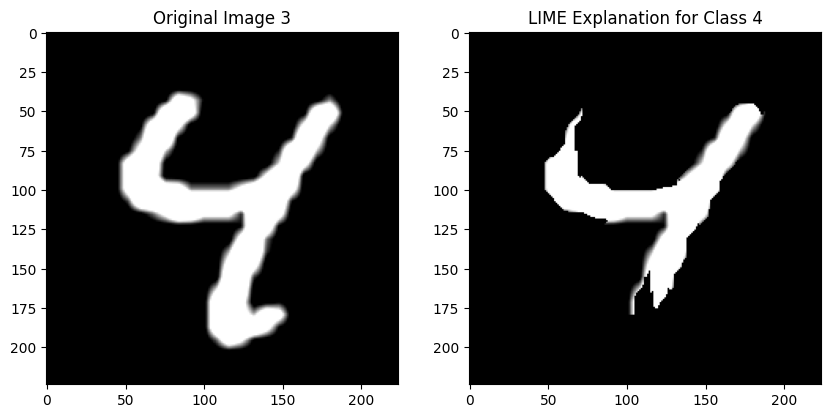

Predicted Class: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

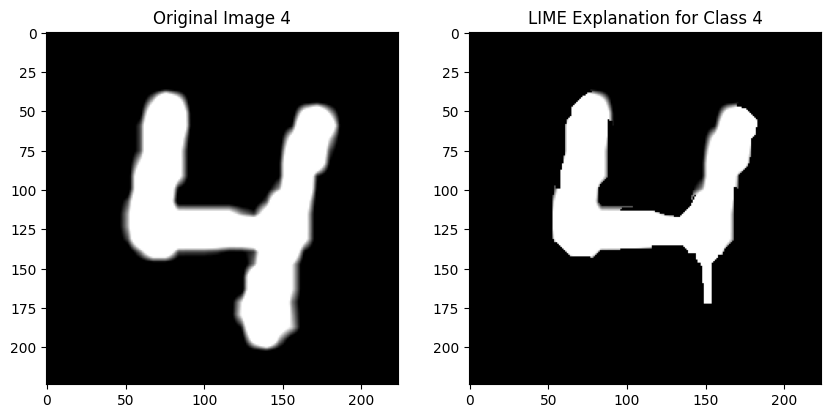

Predicted Class: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

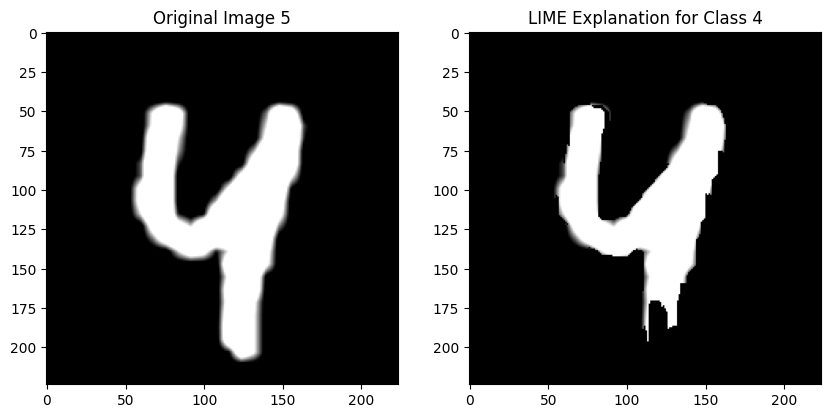

In [ ]:
import random
from lime import lime_image
import matplotlib.pyplot as plt
import numpy as np

# Function to make a prediction with the model
def predict_fn(images):
    model.eval()
    images = torch.tensor(images).to(device)  # Convert images to torch.Tensor and move to device
    images = images.permute(0, 3, 1, 2)  # Convert from HWC to CHW format
    with torch.no_grad():
        output = model(images)
        return output.detach().cpu().numpy()

# Select class 4 to display the LIME explanation
label = 4
samples_for_class = samples_per_class[label]

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop for 5 random images from class 4
for i in range(5):
    # Randomly select an image from class 4
    random_image = random.choice(samples_for_class)  # Select a random image from class 4

    # Preprocess the image and move it to the device
    image = random_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make a prediction with the model
    output = model(image)
    predicted_class = torch.argmax(output, 1).item()
    print(f"Predicted Class: {predicted_class}")

    # Convert the image to a format LIME can work with (HWC)
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

    # Compute the LIME explanation
    explanation = explainer.explain_instance(image_np, predict_fn, top_labels=10, hide_color=0, num_samples=1000)

    # Visualize the explanation for the predicted class
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    ax[0].imshow(image_np)
    ax[0].set_title(f"Original Image {i+1}")

    # Display the LIME heatmap
    lime_img, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=True)
    ax[1].imshow(lime_img)
    ax[1].set_title(f"LIME Explanation for Class {predicted_class}")

    plt.show()




Predicted Class: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

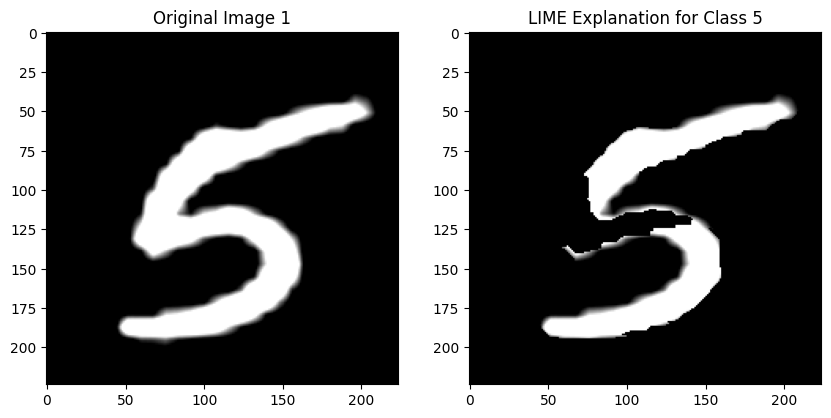

Predicted Class: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

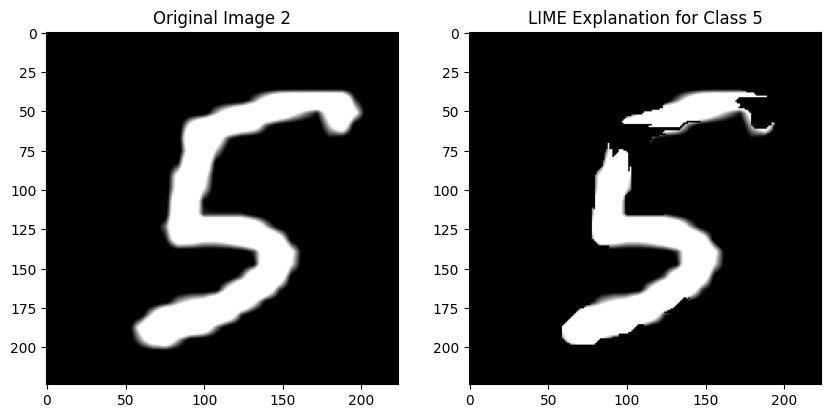

Predicted Class: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

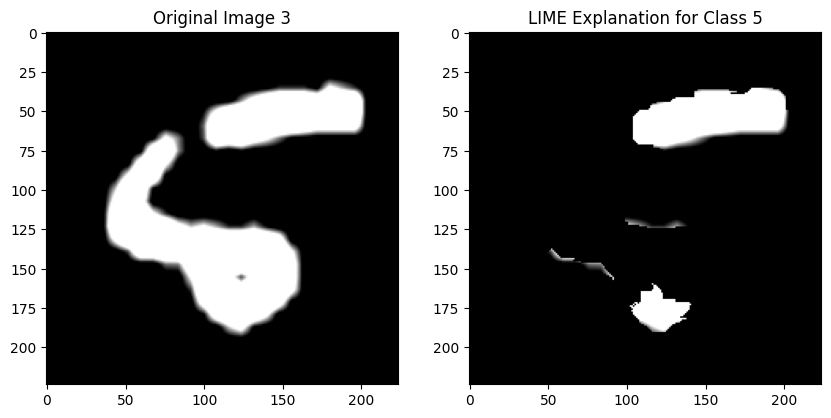

Predicted Class: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

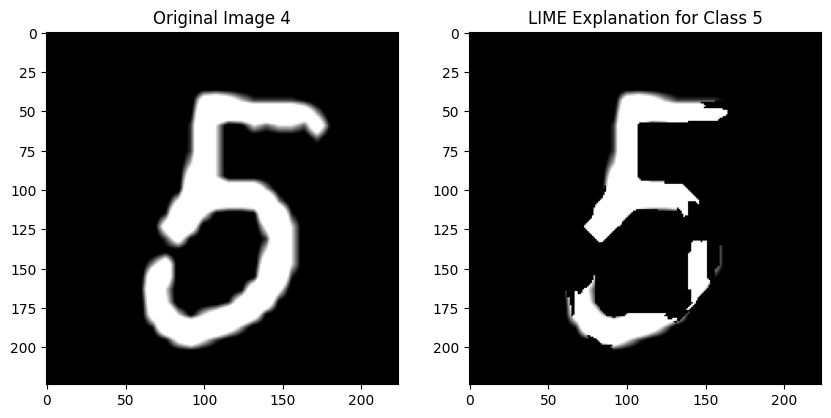

Predicted Class: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

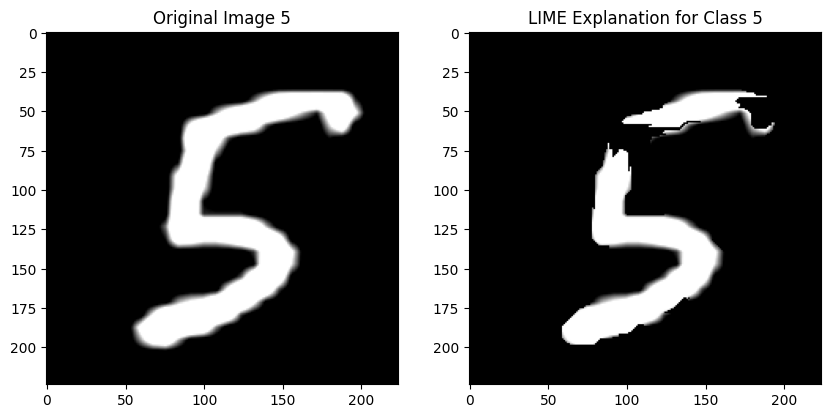

In [ ]:
# Function to make a prediction with the model
def predict_fn(images):
    model.eval()
    images = torch.tensor(images).to(device)  # Convert images to torch.Tensor and move to device
    images = images.permute(0, 3, 1, 2)  # Convert from HWC to CHW format
    with torch.no_grad():
        output = model(images)
        return output.detach().cpu().numpy()

# Select class 5 to display the LIME explanation
label = 5
samples_for_class = samples_per_class[label]

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop for 5 random images from class 5
for i in range(5):
    # Randomly select an image from class 5
    random_image = random.choice(samples_for_class)  # Select a random image from class 5

    # Preprocess the image and move it to the device
    image = random_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make a prediction with the model
    output = model(image)
    predicted_class = torch.argmax(output, 1).item()
    print(f"Predicted Class: {predicted_class}")

    # Convert the image to a format LIME can work with (HWC)
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

    # Compute the LIME explanation
    explanation = explainer.explain_instance(image_np, predict_fn, top_labels=10, hide_color=0, num_samples=1000)

    # Visualize the explanation for the predicted class
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    ax[0].imshow(image_np)
    ax[0].set_title(f"Original Image {i+1}")

    # Display the LIME heatmap
    lime_img, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=True)
    ax[1].imshow(lime_img)
    ax[1].set_title(f"LIME Explanation for Class {predicted_class}")

    plt.show()

***FINAL REPORT***


###Dataset explenation:
The dataset used in this project is the MNIST dataset, a well-known dataset in the machine learning community, particularly used for image classification tasks. It consists of 28x28 grayscale images of handwritten digits (0 through 9). Each image is labeled with the corresponding digit, making it a supervised learning dataset. In this project, the images are processed to fit the input requirements of a pre-trained DenseNet121 model, which was originally trained on the ImageNet dataset.

###Dataset Structure:

Training set: 60,000 images of handwritten digits.

Test set: 10,000 images of handwritten digits used in this project.

Image Preprocessing:

The images are converted from grayscale (1 channel) to RGB (3 channels) for compatibility with the DenseNet model.

Images are resized to 224x224 pixels to match the input dimensions expected by DenseNet.

Normalization: The images are normalized to the mean and standard deviation values used for ImageNet, as the model was pre-trained on ImageNet.

Analysis of Saliency Maps:
The saliency maps generated using various Explainable AI (XAI) techniques such as Integrated Gradients, provide valuable insights into how the model makes decisions. Below is a comparison of the saliency maps for correct and incorrect predictions:

###Correct Predictions:

For correct classifications, the saliency maps especially from Integrated Gradients  highlight the areas that are most relevant to the digit class, such as key features of the handwritten digit (e.g., loops in the number 6, or the straight lines in the number 1).

IME (Local Interpretable Model-agnostic Explanations)
LIME is a model-agnostic explainability technique that helps interpret black-box models by locally approximating them with interpretable models. The key steps in using LIME with this CNN model are as follows:

Image Selection: A random image from the MNIST dataset (e.g., class 4 or class 5) is selected for analysis.

Prediction: The model predicts the class of the image.

LIME Explanation: LIME generates an explanation by perturbing the input image and observing how the model's output changes. It then fits a simpler, interpretable model (such as a linear classifier) to approximate the behavior of the model in the local region around the selected image.

Heatmap Generation: A heatmap is produced by LIME, highlighting the regions of the image that have the most significant impact on the model's prediction. Brighter areas in the heatmap correspond to more important regions.

Key Findings Using LIME:
LIME explanations for class 4 and class 5 show that the model focuses primarily on specific regions of the image (e.g., the digits themselves) rather than on background noise.

The heatmaps generated by LIME help confirm that the model is using the relevant features (i.e., the structure and shapes of the digits) to make its predictions, which aligns with human intuition.

Integrated Gradients is a gradient-based technique for model interpretability that attributes the prediction to each feature in the input image by integrating gradients along the path from a baseline (e.g., a blank image) to the actual input.

Image Selection: A random image from the selected class is chosen for analysis.

Prediction: The model makes a prediction for the selected image.

Attribution Calculation: Integrated Gradients computes the attributions by evaluating the gradients of the model’s output with respect to the input image, integrated along the path from the baseline image.

Visualization: The attributions are visualized as a heatmap, with higher values indicating the regions of the image that contributed the most to the model's decision.

Key Findings Using Integrated Gradients:
The Integrated Gradients heatmap for both class 4 and class 5 highlight the regions corresponding to the main parts of the digits. This suggests that the model is focusing on the relevant parts of the image (i.e., the digits) rather than irrelevant features such as noise or background pixels.

The method provides a smooth and continuous explanation, where attribution values gradually increase along the path from the baseline to the actual image.


In cases of incorrect classifications, the saliency maps tend to focus on less important or irrelevant features of the image, which may be due to noise or irrelevant visual patterns.

The LIME method, by perturbing the image, shows how local changes in the image lead to misclassifications.

By comparing these saliency maps, we can better understand the specific parts of the image that cause the model to make mistakes, providing opportunities for model improvement or data augmentation.

###Explainable System :

An explainable system aims to provide transparent and interpretable outputs for model predictions, enabling end-users to understand how decisions are made. While the current model uses XAI techniques to explain its decisions, there is room to further develop a fully explainable system that could offer even greater insights into its functioning.

Key Components of a Fully Explainable System:
Input Preprocessing: An explainable system should provide transparency in the preprocessing pipeline, such as how the grayscale images are converted to RGB or how the resizing process might affect the model’s decision.

Model Explanation Layer: The system could implement an intermediate layer that shows which specific features (such as edges or corners in the digit images) are used by the model to classify the images. This could be achieved by employing techniques like Layer-wise Relevance Propagation (LRP) alongside Grad-CAM to further interpret which neural activations drive the model’s decision.

Feedback Mechanism: The system could allow users to manipulate the image (e.g., by modifying specific regions) to observe how these changes affect the classification, thus providing an interactive method for understanding the model's reasoning. LIME or SHAP could be used to show the effect of these perturbations on the model’s output.

Error Analysis: When the model makes incorrect predictions, the explainable system could offer a detailed breakdown of which regions or features led to the wrong decision. Additionally, the system could suggest possible corrections (e.g., pointing out ambiguities in the image that caused misclassification).

User Interpretation: For non-technical users, the system could generate simple, natural language explanations summarizing why the model made a particular decision, using the saliency maps as a foundation for these explanations.

By incorporating these elements, a fully explainable system would provide users with a clearer understanding of how the model interprets data, improves trust in its predictions, and allows for better debugging and model improvement.

###INSIGHTS

The system  could be enhanced by introducing a global explanation component, helping to gain a deeper and higher-level understanding of the model’s decision-making. Here's how it could work:

Local Explanations for Each Prediction:

Grad-CAM: Provides an attention map showing which parts of the image influenced the prediction the most. Grad-CAM highlights specific regions that contributed to the result, indicating the most relevant features.

Occlusion Map: Masks portions of the image and observes how removing certain areas affects the classification. If the image loses importance in a specific region, the model's accuracy decreases, indicating that part is essential for classification.

Integrated Gradients: Allows the attribution of importance to each pixel, showing which areas are more responsible for the final decision. Techniques like Integrated Gradients help visualize which features the model finds most important.

LIME (Local Interpretable Model-agnostic Explanations): Provides a more interpretable explanation for a specific prediction by perturbing the image and observing how the model responds to changes. This approach is useful for analyzing the model's sensitivity to local variations in the input.

SHAP: Analyzes the influence of each pixel or group of pixels in determining the predicted class. SHAP provides a global importance score that can help understand how the model uses each part of the image.

Global Explanations of the Model: To gain a more global understanding of the model, the following techniques could be introduced:

Feature Map Visualization: Since the DenseNet model consists of multiple convolutional blocks, the internal feature maps can be visualized to understand how patterns are extracted during training. Visualizing feature maps allows you to observe which global features are detected by the model (e.g., shapes, edges, textures), helping to understand how the model responds to various inputs.

Class Activation Mapping (CAM): This approach can be applied at the class level to see the general areas the model considers for each class. Unlike Grad-CAM, CAM can provide a more "general" representation of the importance of areas during classification.

Analysis of Distances in Feature Space: Using t-SNE or other dimensionality reduction techniques, you can visualize how different classes are distributed in the feature space, observing the separation between classes and understanding whether the model is generalizing correctly or if there are overlapping areas between classes that might be problematic.

Adversarial Networks for Generating Counterexamples: To study the decision boundaries of the model, counterexamples can be generated, i.e., images that are close to training data but belong to different classes. Analyzing how the model behaves on these examples can provide useful insights into its decision-making process globally.

Global Saliency Maps: Beyond visualizing local details, global saliency maps can be generated that describe how each pixel contributes to the classification globally. Using techniques like Saliency Gradients or Guided Backpropagation, visualizations can be created to show which areas of the image are generally more relevant to the model.

Long-Term Model Interpretability: Another useful approach is to examine how the model changes and improves over time during training. By recording and visualizing prediction and activation changes during training, a deeper understanding can be gained of how the model learns.

How to Further Improve the System:
Model Optimization: Integrate the system with a continuous optimization window that allows the model to better learn representations. This could involve using fine-tuning approaches to adapt DenseNet better to the specific dataset.

Hyperparameter Tuning: Optimize the training parameters to get more robust models, such as choosing an appropriate learning rate, batch size, and regularization strategies (dropout, weight decay).

Real-time Performance Monitoring: Use a monitoring system to get feedback on the models during training and dynamically adjust the interpretability process so that better insights can be obtained throughout the model lifecycle.


The system described is already comprehensive for most local interpretability techniques, but improving it with more detailed global analysis will help make the model fully explainable. Combining these explanations allows not only understanding what happens in each individual prediction but also why the model behaves in a particular way, which is valuable in contexts where model transparency is crucial.